# Calibration of Instant RM

Before running this notebook, please ensure Instant RM is installed by following the [instructions in the README](../README.md#Installation). We also recommend starting with the [Tutorial notebook](Tutorial.ipynb) to familiarize yourself with Instant RM fundamentals before diving into this calibration-focused notebook

This notebook illustrates, using synthetic ground-truth, how Instant RM could be calibrated through gradient descent.

We consider a scene with geometry identical to the [Etoile scene from Sionna](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.scene.etoile).
This scene contains the area around the Arc de Triomphe in Paris.
The scene was created with data downloaded from [OpenStreetMap](https://www.openstreetmap.org) and
the help of [Blender](https://www.blender.org) and the [Blender-OSM](https://github.com/vvoovv/blender-osm)
and [Mitsuba Blender](https://github.com/mitsuba-renderer/mitsuba-blender) add-ons.
The data is licensed under the [Open Data Commons Open Database License (ODbL)](https://openstreetmap.org/copyright).

![scene](img/etoile.png)

A path loss map that serves as ground-truth is generated using the following materials:
- `itu_very_dry_ground` for the ground
- Materials randomly chosen from `itu_concrete`, `itu_marble`, `itu_brick`, and `itu_wood` for the walls
- `itu_metal` for the roofs

Details on these materials can be found [on the Sionna website](https://nvlabs.github.io/sionna/api/rt.html#radio-materials).

We then consider the following experiment: Using the same geometry, the properties of the six considered materials are replaced by randomly generated ones.
Then, gradient descent is iteratively performed to minimize the symmetric mean absolute percentage error (SMAPE) between the traced path loss map $\mathbf{m}$ and the ground-truth $\mathbf{m_{gt}}$ until convergence:

$$
\ell(\mathbf{m_{gt}}, \mathbf{m}) = \mathbb{E} \left\{ \frac{ \lvert\mathbf{m_{gt}} - \mathbf{m} \rvert}{\mathbf{m_{gt}} + \mathbf{m}} \right\}
$$

where averaging is over cells with non-zero coverage. Moreover, only 1% of the path loss map is used for calibration to simulate sparse measurements.

In [1]:
import numpy as np
import pickle

import mitsuba as mi
import drjit as dr

%matplotlib inline
import matplotlib.pyplot as plt

from instant_rm import MapTracer, PathlossMapRBPTracer

# Setup

We start by loading the scene, which also contains ground-truth values of the material properties. We set the numpy seed for reproducible results.

In [2]:
# Load Mitsuba scene
scene = mi.load_file("../scenes/etoile_calibration/etoile_calibration.xml")
params = mi.traverse(scene)

# Set the numpy seed
np.random.seed(1)

Next, we define the transmitter and measurement plane:

In [3]:
# Transmitter configuration
tx_position = np.array([68.5, 33.0, 30.0])
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

# Measurement plane settings
mp_center = np.array([0.0, 0.0, 1.5])
mp_orientation = np.array([0., 0., 0.])
mp_size = np.array([500., 500.])
mp_cell_size = np.array([1.0, 1.0])

The next cell defines the parameters used for tracing of the radio maps.

To compute a high-quality ground-truth path loss map $\mathbf{m_{gt}}$, we use $10^9$ samples, a maximum depth of $100$, and no Russian roulette.

However, when iteratively computing path loss maps $\mathbf{m}$ for calibration, only $10^7$ samples are used with a maximum depth of $10$ to speed-up the process. Russian roulette starting from the $5^{th}$ bounce is also enabled.

In [4]:
##################################
# Calibration parameters
#################################
# Number of samples
num_samples = int(1e7)
# Maximum depth
max_depth = 10
# Russian roulette
rr_depth = 5

##################################
# Ground-truth parameters
#################################
# Number of samples
num_samples_gt = int(1e9)
# Maximum depth
max_depth_gt = 100

The following cell defines the parameters for iterative gradient descent, as well as the ratio of cells used for calibration. This ratio is set to 1% in this notebook to simulate calibration from sparse measurements.

In [5]:
# Number of gradient descent iterations
num_iterations = 3000
# Learning rate
lr = 1e-2
# Ratio of the the path loss map used for calibration
gt_keep_ratio = 0.01 # 1%

As in [1], we use an over-parametrization of the trainable material properties to avoid convergence to poor local minima.

Only smooth materials are considered in this notebook, and therefore only the real and imaginary components of the relative permittivities of the materials need to be calibrated.

Parametrization of these quantities is achieved by defining a read-out vector $\mathbf{u}$ shared by all trainable properties, as well as a pair of vectors $\{ \mathbf{v_r}, \mathbf{v_i} \}$ for every radio material.
The value of the real component of the relative permittivity $\epsilon_r$ and imaginary component of the relative permittivity $\epsilon_i$ are then parametrized as follows:

$$
\begin{align}
    \epsilon_r &= \exp{\left( \mathbf{u}^{T} \cdot \mathbf{v_r} \right)} + 1\\
    \epsilon_i &= \exp{\left( \mathbf{u}^{T} \cdot \mathbf{v_i} \right)}
\end{align}
$$

Note that this parametrization ensures that $\epsilon_r > 1$ and $\epsilon_i > 0$.

In [6]:
# Size of the over-parametrization vectors
ovp_dim = 4

# Utilities that compute material properties
def eta_r(u, v_r):
    return dr.exp(dr.dot(u,v_r)/dr.sqrt(ovp_dim)) + 1.0

def eta_i(u, v_i):
    return dr.exp(dr.dot(u,v_i)/dr.sqrt(ovp_dim))

Finally, we define the lower and upper bounds of the colorbar for plotting radio maps.

In [7]:
# Path loss
vmin_pl = -120
vmax_pl = -80
# Delay spread
vmin_ds = 0
vmax_ds = 500
# Absolute logarithmic error on path loss
vmin_err_pl = 0
vmax_err_pl = 10
# Relative absolute error on delay spread
vmin_err_ds = 0.0
vmax_err_ds = 5.

# Ground-truth

The following cell computes radio maps that are used as ground-truth.

In [8]:
# Trace the ground-truth radio maps
tracer = MapTracer(scene, fc, tx_pattern, tx_slant_angle,
                   mp_center, mp_orientation, mp_size, mp_cell_size,
                   num_samples_gt, max_depth_gt)
pm_gt,rdsm_gt,mdam_gt,mddm_gt = tracer(tx_position, tx_orientation)
pm_gt = pm_gt.numpy()
rdsm_gt = rdsm_gt.numpy()
mdam_gt = mdam_gt.numpy()
mddm_gt = mddm_gt.numpy()

Next, we compute the path loss map in dB, and the direction spread of arrival (DSA) and departure (DSD) maps from the mean direction of arrival and departure maps.

In [9]:
# Path loss map in dB
# Cells for which path loss equal to zero have no coverage. Values for these cells are
# set to NaN for visualization.
pm_gt_db = np.where(pm_gt == 0., np.nan, 10.*np.log10(pm_gt + 1e-12))
# DSA and DSD maps
# Due to numerical errors, the norm of the direction vector can be
# slightly higher than one. We clip it to (0,1) to avoid warnings.
norm_dsam_gt = np.clip(np.linalg.norm(mdam_gt, axis=-1), 0., 1.)
dsam_gt = np.sqrt(1-norm_dsam_gt**2)
#
norm_dsdm_gt = np.clip(np.linalg.norm(mddm_gt, axis=-1), 0., 1.)
dsdm_gt = np.sqrt(1-norm_dsdm_gt**2)

Finally, we store the ground-truth value of the materials for later comparison. Note that because only smooth materials are considered, we only need to store the relative permittivities.

In [10]:
# List of materials used in the scene
mat_names = [s.split(".")[0] for s in params.keys()]
mat_names = [s for s in mat_names if s.startswith("mat-")]
mat_names = [s.split('-')[1] for s in mat_names]
mat_names = list(np.unique(mat_names))
# Material properties
eta_r_gt = {} # Real component of the relative permittivity
eta_i_gt = {} # Imaginary component of the relative permittivity
for mat_name in mat_names:
    eta_r_gt[mat_name] = params[f'mat-{mat_name}.eta_r'].numpy()[0]
    eta_i_gt[mat_name] = params[f'mat-{mat_name}.eta_i'].numpy()[0]

We then visualize the ground-truth radio maps. Note that only the path loss map is used for calibration in the next section.

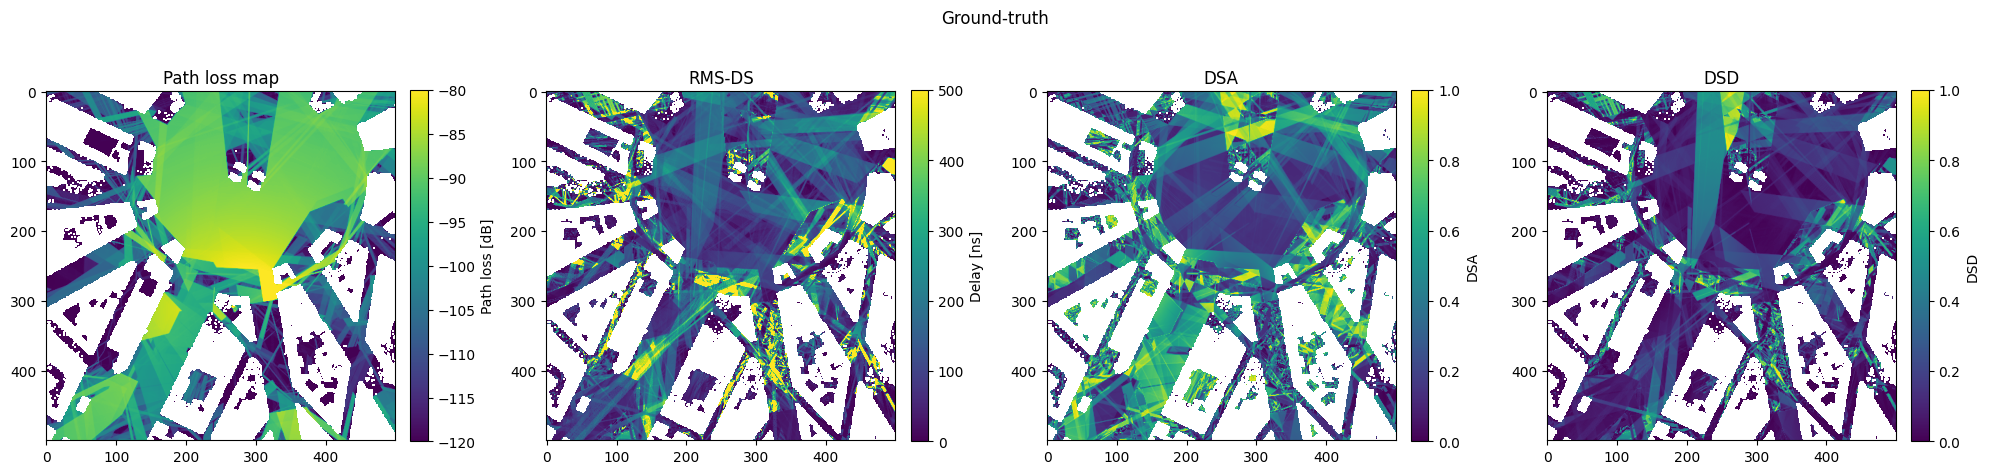

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Ground-truth")
#
ax1.set_title("Path loss map")
im = ax1.imshow(pm_gt_db, vmin=vmin_pl, vmax=vmax_pl)
fig.colorbar(im, label="Path loss [dB]", fraction=0.046, pad=0.04)
#
ax2.set_title("RMS-DS")
im = ax2.imshow(rdsm_gt, vmin=vmin_ds, vmax=vmax_ds)
fig.colorbar(im, label="Delay [ns]", fraction=0.046, pad=0.04)
#
ax3.set_title("DSA")
im = ax3.imshow(dsam_gt, vmin=0.0, vmax=1.0)
fig.colorbar(im, label="DSA", fraction=0.046, pad=0.04)
#
ax4.set_title("DSD")
im = ax4.imshow(dsdm_gt, vmin=0.0, vmax=1.0)
fig.colorbar(im, label="DSD", fraction=0.046, pad=0.04)
#
fig.tight_layout()

# Calibration

We start by discarding most elements of the ground-truth path loss map. The percentage of the path loss map that is used for calibration is configured by the `gt_keep_ratio` variable. The cells that are kept for calibration form a uniform grid over the ground-truth path loss map.

In [12]:
s = np.sqrt(1./gt_keep_ratio)
s = int(s)
training_pm_mask = np.full(pm_gt.shape, True) # Mask all cells...
training_pm_mask[::s,::s] = False # ... and then unmask only a fraction of the map

We next visualize the ground-truth mask.

Number of cells used for training: 1775 out of 250000


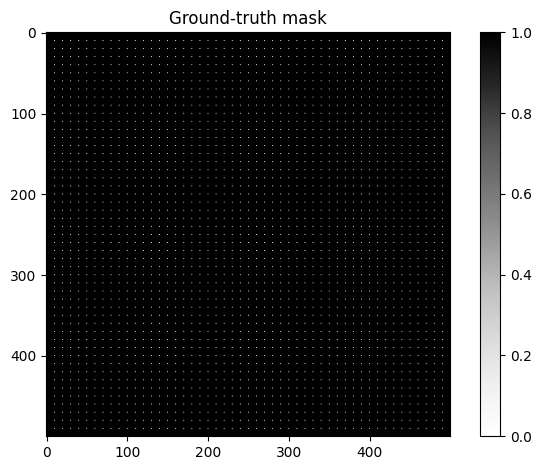

In [13]:
plt.figure()
plt.title("Ground-truth mask")
plt.imshow(training_pm_mask, cmap="Greys")
plt.colorbar()
plt.tight_layout()

num_training_cells = np.sum(np.logical_and(np.logical_not(training_pm_mask),
                                           pm_gt > 0.0)) # We don't count cells with no coverage
print(f"Number of cells used for training: {num_training_cells} out of {pm_gt.shape[0]*pm_gt.shape[1]}")
training_pm_mask = mi.TensorXb(training_pm_mask)

We next define a loss function. We use the SMAPE between the traced path loss map and the masked ground-truth, as stated at the beginning of this notebook.
This loss is similar to the one used in [1]. Note that the masked cells and the cells with no coverage are discarded.

In [14]:
def loss_function(pm):
    # SMAPE
    l = dr.abs(pm - pm_gt)/(pm + pm_gt)
    # Discard cells with no coverage and masked ones
    l = dr.select(dr.isnan(l) | training_pm_mask, 0.0, l)
    # Average
    loss = dr.sum(l)/num_training_cells
    return loss

The next cell instantiates the Adam optimizer that is used to perform iterative gradient descent.

In [15]:
opt = mi.ad.Adam(lr=lr, mask_updates=True)

We then instantiate and initialize the vectors used to over-parametrize the material properties. A normal distribution is used to randomly initialize these vectors.

In [16]:
# Shared read-out vector
u = np.random.normal(size=[ovp_dim])
u = mi.Float(u)
opt['u'] = u
# Embeddings, one for each radio material property
for mat_name in mat_names:
    # eta_r
    v_r = np.random.normal(size=[ovp_dim])
    v_r = mi.Float(v_r)
    opt[f"{mat_name}-eta_r"] = v_r
    # eta_i
    v_i = np.random.normal(size=[ovp_dim])
    v_i = mi.Float(v_i)
    opt[f"{mat_name}-eta_i"] = v_i

# Initialize the trainable material properties of the scene
for mat_name in mat_names:
    v = opt[f"{mat_name}-eta_r"]
    params[f"mat-{mat_name}.eta_r"] = eta_r(u, v)
for mat_name in mat_names:
    v = opt[f"{mat_name}-eta_i"]
    params[f"mat-{mat_name}.eta_i"] = eta_i(u, v)
params.update();

We save a copy of the initial values of the trainable material properties for later visualization.

In [17]:
init_u = opt['u'].numpy()
eta_r_init = {}
eta_i_init = {}
for mat_name in mat_names:
    # eta_r
    eta_r_init[mat_name] = params[f"mat-{mat_name}.eta_r"].numpy()
    # eta_i
    eta_i_init[mat_name] = params[f"mat-{mat_name}.eta_i"].numpy()

We are now ready to calibrate the materials using gradient descent and [using radiative backpropagation (RBP)](Tutorial.ipynb#Radiative-backpropagation).
First, we instantiate the tracer.

In [18]:
tracer = PathlossMapRBPTracer(scene, fc, tx_pattern, tx_slant_angle,
                              mp_center, mp_orientation, mp_size, mp_cell_size,
                              num_samples, max_depth,
                              rr_depth=rr_depth)

Next, we run the calibration loop.

In [19]:
for it in range(num_iterations):
    # Compute the path loss map, loss, and gradients
    # Note: As the RBP tracer is used, gradients are stored internally
    _, loss = tracer(tx_position, tx_orientation, func_loss=loss_function)

    # Take a gradient descent step with the optimizer
    opt.step()

    # Update the scene state with the updated values
    u = opt['u']
    for mat_name in mat_names:
        v =  opt[f"{mat_name}-eta_r"]
        params[f"mat-{mat_name}.eta_r"] = eta_r(u, v)
        v =  opt[f"{mat_name}-eta_i"]
        params[f"mat-{mat_name}.eta_i"] = eta_i(u, v)
    params.update()

    # Print progress
    if it % 100 == 0:
        loss = loss.numpy()[0]
        print(f"Iteration {it}. Loss: {loss}", end="\r")

We store the calibrated radio material properties for visualization in the next section.

In [20]:
eta_r_cal = {}
eta_i_cal = {}
for mat_name in mat_names:
    eta_r_cal[mat_name] = params[f"mat-{mat_name}.eta_r"].numpy()
    eta_i_cal[mat_name] = params[f"mat-{mat_name}.eta_i"].numpy()

# Visualization

We now visualize the results of the calibration process. To that aim, the next cell defines a set of utilities.

In [21]:
def plot_radio_maps(etas_r, etas_i):
    """
    Plots the radio maps
    """

    # Instantiate the tracer
    tracer = MapTracer(scene, fc, tx_pattern, tx_slant_angle,
                       mp_center, mp_orientation, mp_size, mp_cell_size,
                       num_samples_gt, max_depth_gt)

    for mat_name in mat_names:
        params[f"mat-{mat_name}.eta_r"] = etas_r[mat_name]
        params[f"mat-{mat_name}.eta_i"] = etas_i[mat_name]
    params.update()

    pm,rdsm,mdam,mddm = tracer(tx_position, tx_orientation)
    pm = pm.numpy()
    rdsm = rdsm.numpy()
    mdam = mdam.numpy()
    mddm = mddm.numpy()

    # DSA and DSD
    # Due to numerical errors, the norm of the direction vector can be
    # slightly higher than one. We clip it to (0,1) to avoid warnings.
    norm_dsam = np.clip(np.linalg.norm(mdam, axis=-1), 0., 1.)
    dsam = np.sqrt(1-norm_dsam**2)
    #
    norm_dsd = np.clip(np.linalg.norm(mddm, axis=-1), 0., 1.)
    dsdm = np.sqrt(1-norm_dsd**2)

    return pm, rdsm, dsam, dsdm

def to_db(x):
    """
    Linear to dB
    """
    # Cells for which path loss equal to zero have no coverage. Values for these cells are
    # set to NaN for visualization.
    return np.where(x == 0.0, np.nan, 10.*np.log10(x+1e-12))

def reflection_coefficient(er, ei, theta_i):
    """
    Computes the average Fresnel coefficient squared amplitude

    1/2 * ( |r_s|^2 + |r_p|^2 )

    for the incident angle `theta_i` and complex relative
    permittivity `er - 1j*ei`
    """

    cos_theta_i = dr.cos(theta_i)
    eta = mi.Complex2f(er, -ei)
    m = mi.mueller.specular_reflection(cos_theta_i, eta)
    r1 = m[0,0] + m[0,1]
    r2 = m[0,0] - m[0,1]
    r1 = r1.numpy()[0]
    r2 = r2.numpy()[0]
    r = 0.5*(np.square(r1) + np.square(r2))
    return r

We will now trace the radio maps after initialization of the radio materials (prior to calibration) and after their calibration.
This is to visualize the impact of calibrating Instant RM.

We also compute the average Fresnel coefficient squared amplitudes of all materials after initialization of the radio materials and after their calibration. 

In [22]:
# Incident angle for which to evaluate the reflection coefficient
theta_i = np.pi/4.

# After initialization
pm_init, rdsm_init, dsam_init, dsdm_init = plot_radio_maps(eta_r_init, eta_i_init)
pm_init_db = to_db(pm_init)
rs_init = {}
for mat_name in mat_names:
    er = mi.Float(float(eta_r_init[mat_name]))
    ei = mi.Float(float(eta_i_init[mat_name]))
    rs_init[mat_name] = reflection_coefficient(er, ei, theta_i)

# After calibration
pm_cal, rdsm_cal, dsam_cal, dsdm_cal = plot_radio_maps(eta_r_cal, eta_i_cal)
pm_cal_db = to_db(pm_cal)
rs_cal = {}
for mat_name in mat_names:
    er = mi.Float(float(eta_r_cal[mat_name]))
    ei = mi.Float(float(eta_i_cal[mat_name]))
    rs_cal[mat_name] = reflection_coefficient(er, ei, theta_i)

# Ground-truth
pm_gt_db = to_db(pm_gt)
rs_gt = {}
for mat_name in mat_names:
    er = mi.Float(float(eta_r_gt[mat_name]))
    ei = mi.Float(float(eta_i_gt[mat_name]))
    rs_gt[mat_name] = reflection_coefficient(er, ei, theta_i)

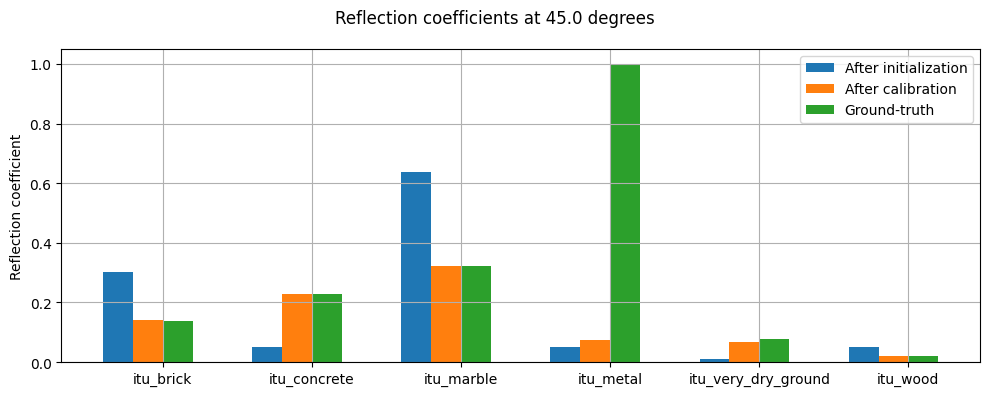

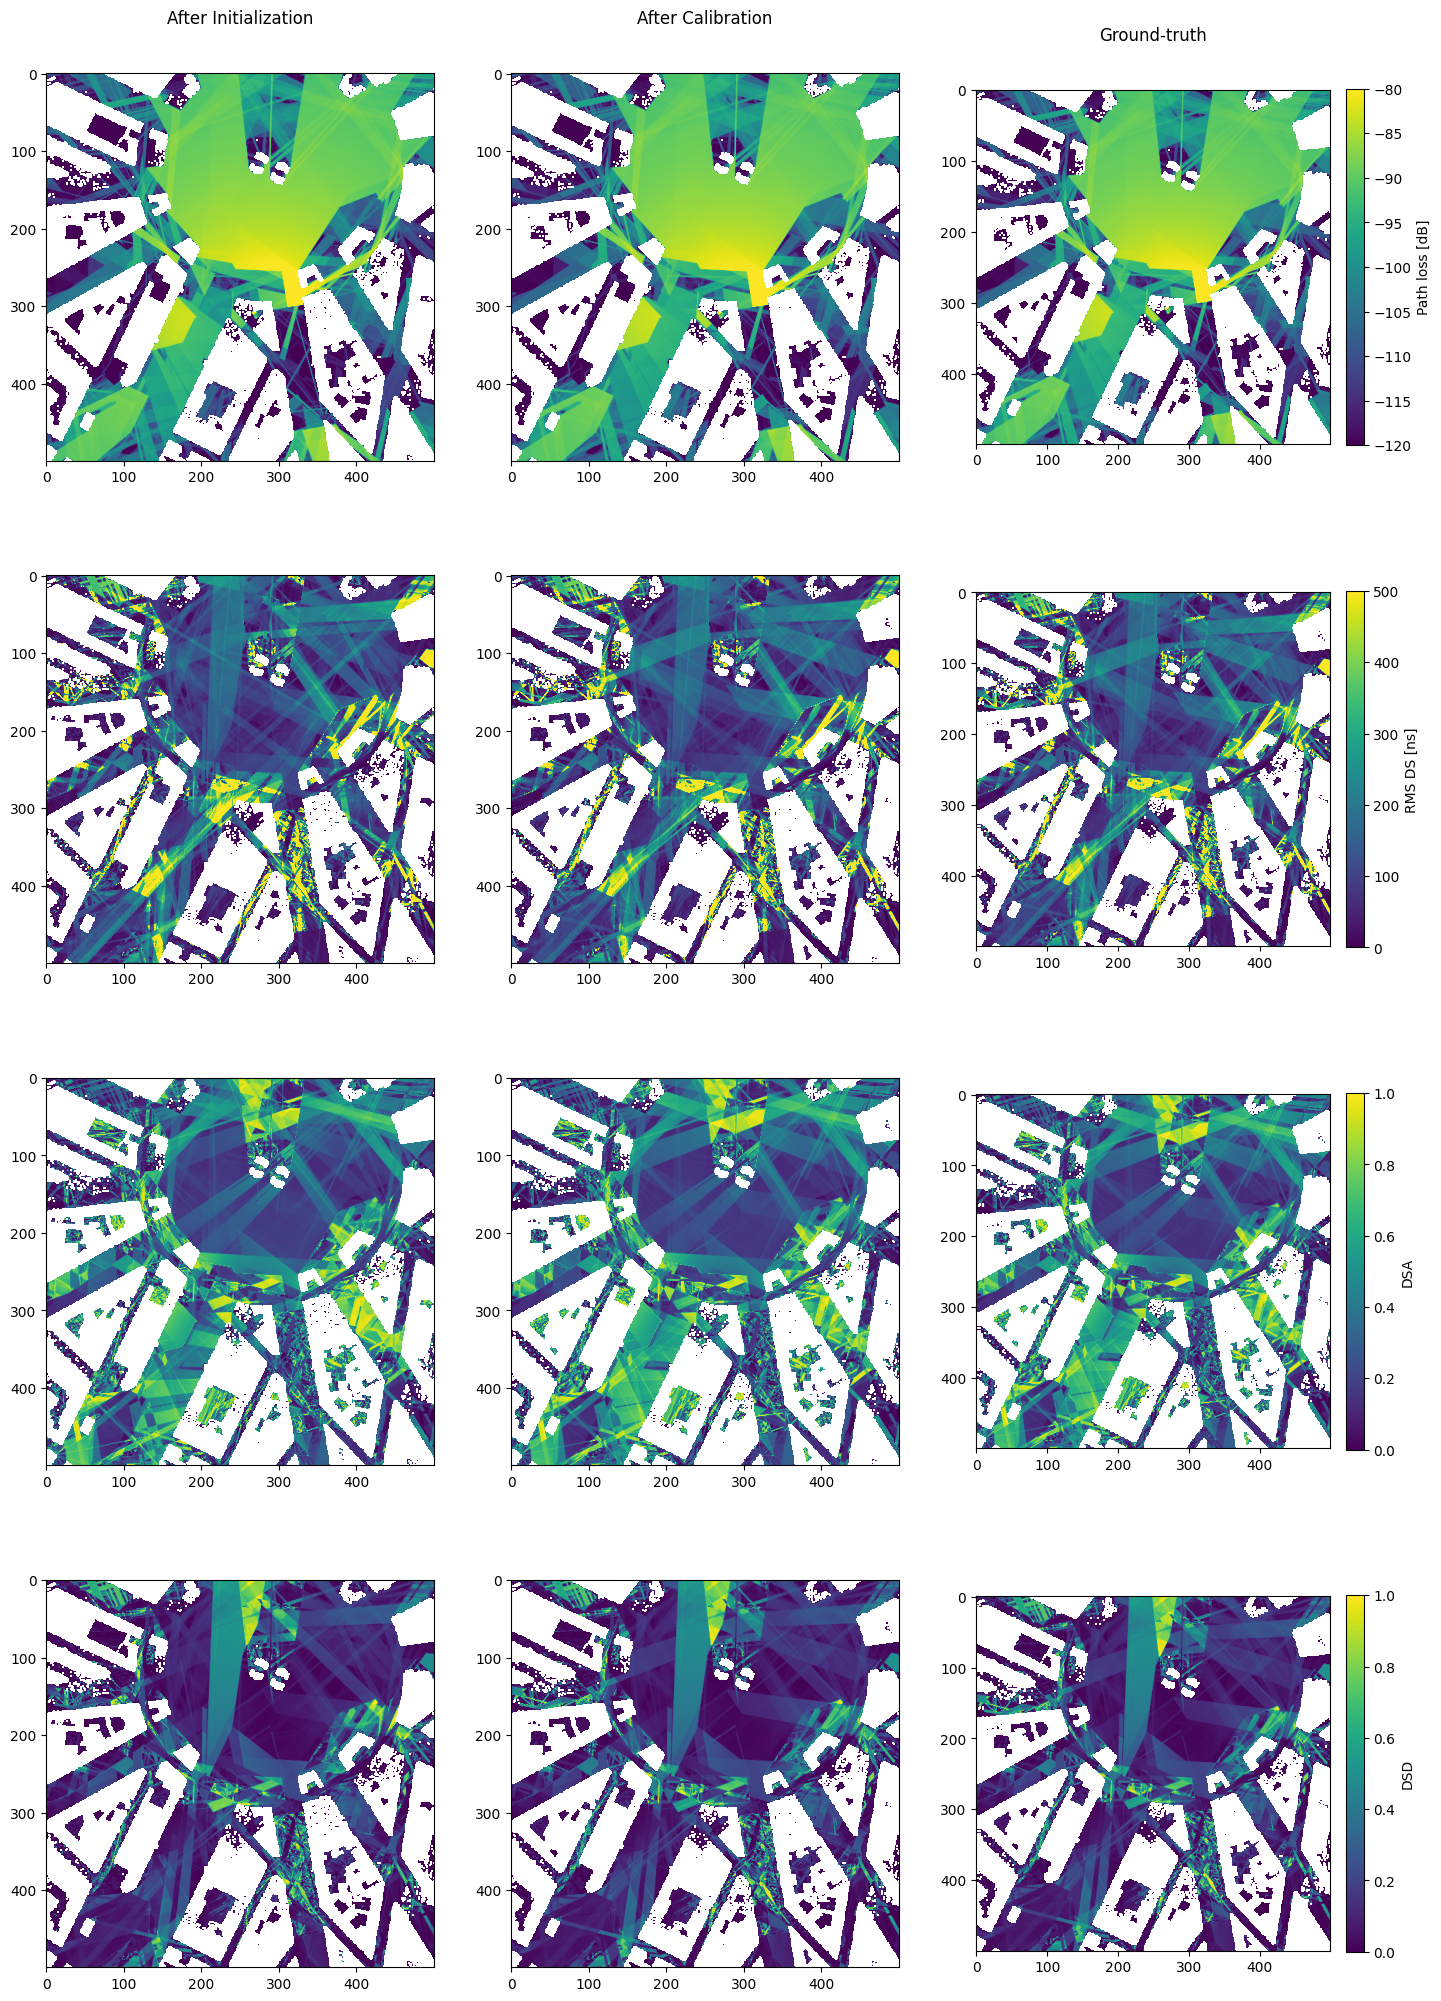

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
fig.suptitle(f"Reflection coefficients at {theta_i*180/np.pi} degrees")
#
bar_width = 0.2
ax.bar(np.arange(1, len(mat_names)+1), rs_init.values(), width=bar_width, label='After initialization')
ax.bar(np.arange(1, len(mat_names)+1)+bar_width, rs_cal.values(), width=bar_width, label='After calibration')
ax.bar(np.arange(1, len(mat_names)+1)+2*bar_width, rs_gt.values(), width=bar_width, label='Ground-truth')
ax.set_xticks(np.arange(1, len(mat_names)+1) + 1.5*bar_width, mat_names)
ax.legend()
ax.grid(True)
ax.set_ylabel("Reflection coefficient")
#
fig.tight_layout()


fig, axs = plt.subplots(4, 3, figsize=(17, 25))
##
## Path loss maps
axs[0,0].set_title("After Initialization\n\n")
im = axs[0,0].imshow(pm_init_db, vmin=vmin_pl, vmax=vmax_pl)
#
axs[0,1].set_title("After Calibration\n\n")
im = axs[0,1].imshow(pm_cal_db, vmin=vmin_pl, vmax=vmax_pl)
#
axs[0,2].set_title("Ground-truth\n\n")
im = axs[0,2].imshow(pm_gt_db, vmin=vmin_pl, vmax=vmax_pl)
fig.colorbar(im, label="Path loss [dB]", fraction=0.046, pad=0.04)
##
## RMS-DS map
im = axs[1,0].imshow(rdsm_init, vmin=vmin_ds, vmax=vmax_ds)
#
im = axs[1,1].imshow(rdsm_cal, vmin=vmin_ds, vmax=vmax_ds)
#
im = axs[1,2].imshow(rdsm_gt, vmin=vmin_ds, vmax=vmax_ds)
fig.colorbar(im, label="RMS DS [ns]", fraction=0.046, pad=0.04)
##
## DSA map
im = axs[2,0].imshow(dsam_init, vmin=0., vmax=1.)
#
im = axs[2,1].imshow(dsam_cal, vmin=0., vmax=1.)
#
im = axs[2,2].imshow(dsam_gt, vmin=0., vmax=1.)
fig.colorbar(im, label="DSA", fraction=0.046, pad=0.04)
##
## DSD map
im = axs[3,0].imshow(dsdm_init, vmin=0., vmax=1.)
#
im = axs[3,1].imshow(dsdm_cal, vmin=0., vmax=1.)
#
im = axs[3,2].imshow(dsdm_gt, vmin=0., vmax=1.)
fig.colorbar(im, label="DSD", fraction=0.046, pad=0.04);

Note that ITU-Metal is only used for the roofs, and therefore is involved in very few paths (if any).

# References

[1] Jakob Hoydis, Fayçal Aït Aoudia, Sebastian Cammerer, Florian Euchner, Merlin Nimier-David, Stephan ten Brink, Alexander Keller, ["Learning Radio Environments by Differentiable Ray Tracing"](https://arxiv.org/abs/2311.18558), arXiv:2311.18558, 2024